 # Python Practice for GP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

#################################################<br>
Load the training data<br>
#################################################

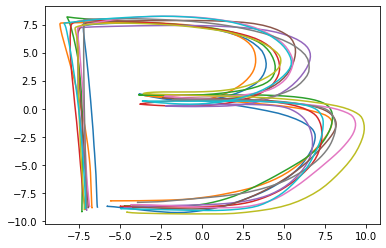

In [2]:
mat = loadmat('../2Dletters/B.mat')
demosNum = 10
dataset = []
for i in range(demosNum):
    data = mat['demos'][0, i]['pos'][0, 0]
    dataset.append(data)
    plt.plot(data[0], data[1])
plt.show()

#################################################<br>
Kernel function<br>
#################################################

In [3]:
def kernel(x1, x2, kh):
    return np.exp(-kh * np.dot(x1-x2, x1-x2))

#################################################<br>
GP learning<br>
#################################################

In [4]:
dt = 0.005 # time interval
dim = 2   # 2D trajectory
kh = 100  # kernel parameter
lb = 0.01 # regularization parameter
pos = dataset[0] # only use the first demonstration for learning
len = pos.shape[1] # length of the demonstration
tau = dt * len # motion duraiton

In [5]:
t0 = np.linspace(dt, tau, num=len) # time input
Kc = np.zeros((len, len)) # kernel matrix
Y = np.zeros((len, dim)) # trajectory output

In [6]:
for i in range(len):
    for j in range(len):
        Kc[i, j] = kernel(t0[i], t0[j], kh)
    Y[i, :] = pos[:, i]

In [7]:
Kc = np.add(Kc, lb * np.eye(len))
weight = np.matmul(np.linalg.pinv(Kc), Y)

#################################################<br>
GP prediction<br>
#################################################

In [8]:
t = np.linspace(dt, tau, num=int(np.round(len/4))) # set new time steps
# t = np.linspace(dt, 2*tau, num=int(np.round(len/4))) # prediction beyond the training region convergences to the mean

newLen = t.shape[0]
GP_pos = np.zeros((dim, newLen))
ks = np.zeros(len)
for i in range(newLen):
    for j in range(len):
        ks[j] = kernel(t[i], t0[j], kh)
    GP_pos[:, i] = np.matmul(ks, weight) # ks*(Kc+lb*I)^{-1}*Y

#################################################<br>
Plot predicted trajectories<br>
#################################################-

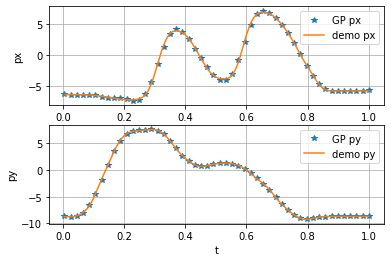

In [9]:
ax1 = plt.subplot(2, 1, 1)
ax1.plot(t, GP_pos[0, :], '*', label='GP px')
ax1.plot(t0, pos[0, :], label='demo px')
ax1.set_ylabel("px")
plt.legend()
ax1.grid()
ax2 = plt.subplot(2, 1, 2)
ax2.plot(t, GP_pos[1, :], '*', label='GP py')
ax2.plot(t0, pos[1, :], label='demo py')
ax2.set_xlabel("t")
ax2.set_ylabel("py")
plt.legend()
ax2.grid()
plt.show()

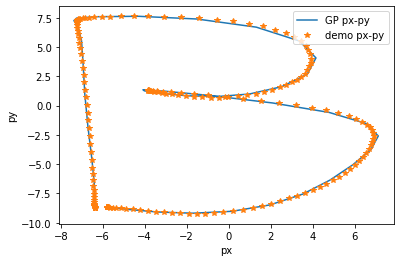

In [10]:
plt.plot(GP_pos[0, :], GP_pos[1, :], label='GP px-py')  # GP trajectory
plt.plot(pos[0, :], pos[1, :], '*', label='demo px-py')  # demonstration
plt.xlabel("px")
plt.ylabel("py")
plt.legend()
plt.show()

In [2]:
# ===== GPR/KRR LOO reproduction (paste & run) =====
import numpy as np
from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

def rbf_kernel(X, Y, length=0.05):
    # X:(n,), Y:(m,) 一维时间的 RBF 核
    X = X.reshape(-1,1); Y = Y.reshape(-1,1)
    d2 = (X - Y.T)**2
    return np.exp(-0.5 * d2 / (length**2))

def krr_fit_predict(t_train, y_train, t_test, length=0.05, lam=1e-6):
    # y_train: (n,) -> 返回 y_pred:(m,)
    K = rbf_kernel(t_train, t_train, length) + lam*np.eye(len(t_train))
    alpha = np.linalg.solve(K, y_train)
    K_s = rbf_kernel(t_test, t_train, length)
    return K_s @ alpha

letters   = ['A','B','G','H']
T         = 200
save_csv  = 'results/reproduction_LOO.csv'
csv_header= ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']

for letter in letters:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[GPR:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        # 训练数据：把所有训练演示的 (t, x/y) 堆叠
        t_tr_all = []; x_tr_all = []; y_tr_all = []
        for p in preps_tr:
            t = np.linspace(0,1,p['pos'].shape[1])
            t_tr_all.append(t)
            x_tr_all.append(p['pos'][0])
            y_tr_all.append(p['pos'][1])
        t_tr = np.concatenate(t_tr_all, axis=0)
        x_tr = np.concatenate(x_tr_all, axis=0)
        y_tr = np.concatenate(y_tr_all, axis=0)

        with timer() as t_train:
            # KRR 没有单独“训练”；这里只是为计时对齐
            pass
        train_ms = t_train()

        with timer() as t_infer:
            t_te = np.linspace(0,1,prep_te['pos'].shape[1])
            x_pred_n = krr_fit_predict(t_tr, x_tr, t_te, length=0.05, lam=1e-6)
            y_pred_n = krr_fit_predict(t_tr, y_tr, t_te, length=0.05, lam=1e-6)
            y_pred_n = np.vstack([x_pred_n, y_pred_n])
        infer_ms = t_infer()

        y_pred = denormalize(y_pred_n, prep_te['stats'])
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred)
        e = endpoint_err(y_true, y_pred)
        j = jerk_score(y_pred, prep_te['dt'])

        append_csv(save_csv, csv_header, ['GPR', letter, fold, m, e, j, train_ms, infer_ms])
        print(f'  fold={fold:02d}  RMSE={m:.4f}  end={e:.4f}  jerk={j:.4f}')
print('GPR reproduction LOO done ->', save_csv)


[GPR:A] demos=10
  fold=00  RMSE=3.2197  end=0.9920  jerk=30413.6898
  fold=01  RMSE=0.6412  end=0.7821  jerk=24675.4502
  fold=02  RMSE=0.5201  end=0.6849  jerk=25378.6246
  fold=03  RMSE=0.3954  end=0.0721  jerk=24933.5655
  fold=04  RMSE=0.6314  end=0.3930  jerk=25180.9575
  fold=05  RMSE=0.4719  end=0.1287  jerk=22185.6005
  fold=06  RMSE=0.5384  end=0.2165  jerk=24280.9173
  fold=07  RMSE=1.5621  end=0.0729  jerk=25201.4030
  fold=08  RMSE=0.5076  end=0.9225  jerk=25146.7940
  fold=09  RMSE=0.5354  end=1.0981  jerk=25272.8393
[GPR:B] demos=12
  fold=00  RMSE=1.4334  end=1.1565  jerk=29757.7139
  fold=01  RMSE=1.4884  end=0.3776  jerk=31612.7137
  fold=02  RMSE=0.8482  end=0.3905  jerk=30883.4286
  fold=03  RMSE=0.5330  end=0.1089  jerk=30509.5064
  fold=04  RMSE=0.8867  end=0.5049  jerk=29969.8737
  fold=05  RMSE=1.7546  end=0.2982  jerk=31300.3992
  fold=06  RMSE=1.8971  end=0.9249  jerk=33718.8730
  fold=07  RMSE=2.1013  end=0.5508  jerk=32229.1738
  fold=08  RMSE=0.8047  end=0.

In [5]:
# ===== GP baseline for MISSING (prefix completion) =====
LETTERS   = ['A','B','G','H']
T         = 200
LENGTH    = 0.06
SIGMA2    = 1e-4
P_LIST    = [0.6, 0.4]      # 可调前缀比例
SAVE_CSV  = 'results/missing_gp.csv'
HDR       = ['method','letter','fold','p','rmse','end_err','jerk','train_ms','infer_ms']

def rbf_kernel(t1, t2, length=LENGTH):
    t1 = np.asarray(t1).reshape(-1,1)
    t2 = np.asarray(t2).reshape(-1,1)
    return np.exp(-0.5*(t1 - t2.T)**2/(length**2))

def gp_fit(alpha_y, K_reg):  # 仅占位（接口一致）
    return

from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

for letter in LETTERS:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[GP-missing:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        t = np.linspace(0,1,T)
        pos_stack = np.stack([p['pos'] for p in preps_tr], axis=0)  # (H,2,T)
        y_mean = pos_stack.mean(axis=0)                             # (2,T)

        for p in P_LIST:
            Lp = int(round(T*p))
            # 训练集(均值轨迹) + 测试前缀作为“强观测”
            t_train = np.concatenate([t, t[:Lp]])
            # x/y 两维分别训练
            y_train_x = np.concatenate([y_mean[0], prep_te['pos'][0, :Lp]])
            y_train_y = np.concatenate([y_mean[1], prep_te['pos'][1, :Lp]])

            # 噪声：均值轨迹用 SIGMA2，前缀观测用更小噪声（更强约束）
            noise = np.concatenate([np.full(T, SIGMA2), np.full(Lp, 1e-6)])

            with timer() as tr_ms:
                K = rbf_kernel(t_train, t_train, LENGTH)
                K_reg = K + np.diag(noise)
                alpha_x = np.linalg.solve(K_reg, y_train_x)
                alpha_y = np.linalg.solve(K_reg, y_train_y)
            train_ms = tr_ms()

            t_query = t
            with timer() as inf_ms:
                Kqx = rbf_kernel(t_query, t_train, LENGTH)
                y_pred_n = np.vstack([Kqx @ alpha_x, Kqx @ alpha_y])  # (2,T)
            infer_ms = inf_ms()

            y_pred = denormalize(y_pred_n, prep_te['stats'])
            y_true = denormalize(prep_te['pos'], prep_te['stats'])
            m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, prep_te['dt'])
            append_csv(SAVE_CSV, HDR, ['GP', letter, fold, p, m, e, j, train_ms, infer_ms])
            print(f'  fold={fold:02d} p={p:.2f}  RMSE={m:.3f} End={e:.3f} Jerk={j:.3f}')

[GP-missing:A] demos=10
  fold=00 p=0.60  RMSE=1.604 End=0.952 Jerk=81030.947
  fold=00 p=0.40  RMSE=2.109 End=0.988 Jerk=82738.166
  fold=01 p=0.60  RMSE=0.428 End=0.790 Jerk=42911.222
  fold=01 p=0.40  RMSE=0.498 End=0.788 Jerk=36608.789
  fold=02 p=0.60  RMSE=0.281 End=0.682 Jerk=44302.542
  fold=02 p=0.40  RMSE=0.377 End=0.680 Jerk=30412.512
  fold=03 p=0.60  RMSE=0.213 End=0.077 Jerk=42891.839
  fold=03 p=0.40  RMSE=0.340 End=0.077 Jerk=38089.413
  fold=04 p=0.60  RMSE=0.318 End=0.391 Jerk=37885.735
  fold=04 p=0.40  RMSE=0.419 End=0.393 Jerk=35153.526
  fold=05 p=0.60  RMSE=0.230 End=0.124 Jerk=44923.634
  fold=05 p=0.40  RMSE=0.279 End=0.133 Jerk=31168.424
  fold=06 p=0.60  RMSE=0.160 End=0.220 Jerk=42539.345
  fold=06 p=0.40  RMSE=0.291 End=0.221 Jerk=35662.192
  fold=07 p=0.60  RMSE=0.813 End=0.075 Jerk=47874.446
  fold=07 p=0.40  RMSE=1.146 End=0.075 Jerk=40918.139
  fold=08 p=0.60  RMSE=0.262 End=0.916 Jerk=29927.946
  fold=08 p=0.40  RMSE=0.424 End=0.916 Jerk=32449.192
  fo

In [7]:
# ===== GP baseline for OBSTACLE (single via-point) =====
LETTERS   = ['A','B','G','H']
T         = 200
LENGTH    = 0.06
SIGMA2    = 1e-4
SAVE_CSV  = 'results/obstacle_gp.csv'
HDR       = ['method','letter','fold','rmse','end_err','jerk','train_ms','infer_ms']

from utils import (load_letter_all, split_indices, denormalize,
                   rmse, endpoint_err, jerk_score, timer, append_csv)

def make_via_point(y_ref, inflate=1.25):
    """简单从参考轨迹中点出一个 via，往法线方向推一点点"""
    mid = y_ref.shape[1]//2
    p  = y_ref[:, mid]                         # 中点
    # 法线方向：用前后差近似
    d  = y_ref[:, min(mid+1, y_ref.shape[1]-1)] - y_ref[:, max(mid-1, 0)]
    if np.linalg.norm(d) < 1e-9:
        n = np.array([0.0, 1.0])
    else:
        n = np.array([-d[1], d[0]]) / (np.linalg.norm(d)+1e-12)
    via = p + inflate * 0.15 * n              # 稍微偏移
    t_v = 0.5                                 # 时间在中点
    return t_v, via

def rbf_kernel(t1, t2, length=LENGTH):
    t1 = np.asarray(t1).reshape(-1,1)
    t2 = np.asarray(t2).reshape(-1,1)
    return np.exp(-0.5*(t1 - t2.T)**2/(length**2))

for letter in LETTERS:
    preps = load_letter_all(letter, T=T, norm='zscore')
    N = len(preps)
    print(f'[GP-obstacle:{letter}] demos={N}')
    for fold in range(N):
        tr_idx, te_idx = split_indices(N, mode='loo', loo_test=fold)
        preps_tr = [preps[i] for i in tr_idx]
        prep_te  = preps[te_idx[0]]

        t = np.linspace(0,1,T)
        pos_stack = np.stack([p['pos'] for p in preps_tr], axis=0)
        y_mean = pos_stack.mean(axis=0)        # (2,T)

        # 生成 via-point（在反归一化坐标系里挑位点，再归一化回去）
        y_mean_denorm = denormalize(y_mean, preps_tr[0]['stats'])
        t_v, via = make_via_point(y_mean_denorm, inflate=1.25)
        # 把 via 归一化，才能和 GP 的训练域一致
        via_n = (via - preps_tr[0]['stats']['mean'].reshape(-1)) / (preps_tr[0]['stats']['std'].reshape(-1)+1e-8)

        t_train = np.concatenate([t, [t_v]])
        noise   = np.concatenate([np.full(T, SIGMA2), [1e-6]])   # via 作为强约束
        y_tx = np.concatenate([y_mean[0], [via_n[0]]])
        y_ty = np.concatenate([y_mean[1], [via_n[1]]])

        with timer() as tr_ms:
            K = rbf_kernel(t_train, t_train, LENGTH)
            K_reg = K + np.diag(noise)
            alpha_x = np.linalg.solve(K_reg, y_tx)
            alpha_y = np.linalg.solve(K_reg, y_ty)
        train_ms = tr_ms()

        with timer() as inf_ms:
            Kqx = rbf_kernel(t, t_train, LENGTH)
            y_pred_n = np.vstack([Kqx @ alpha_x, Kqx @ alpha_y])
        infer_ms = inf_ms()

        y_pred = denormalize(y_pred_n, preps_tr[0]['stats'])  # 用同一 stats 反归一化
        y_true = denormalize(prep_te['pos'], prep_te['stats'])
        m = rmse(y_true, y_pred); e = endpoint_err(y_true, y_pred); j = jerk_score(y_pred, prep_te['dt'])
        append_csv(SAVE_CSV, HDR, ['GP', letter, fold, m, e, j, train_ms, infer_ms])
        print(f'  fold={fold:02d}  RMSE={m:.3f} End={e:.3f} Jerk={j:.3f}')

[GP-obstacle:A] demos=10
  fold=00  RMSE=3.300 End=1.935 Jerk=28083.126
  fold=01  RMSE=1.255 End=2.039 Jerk=26856.608
  fold=02  RMSE=1.295 End=0.876 Jerk=26832.437
  fold=03  RMSE=0.750 End=0.793 Jerk=27149.653
  fold=04  RMSE=0.934 End=0.321 Jerk=28143.997
  fold=05  RMSE=0.983 End=0.565 Jerk=26158.031
  fold=06  RMSE=1.043 End=1.205 Jerk=27080.723
  fold=07  RMSE=1.889 End=0.443 Jerk=30106.249
  fold=08  RMSE=1.158 End=0.445 Jerk=28164.807
  fold=09  RMSE=0.940 End=1.999 Jerk=27022.630
[GP-obstacle:B] demos=12
  fold=00  RMSE=1.595 End=0.357 Jerk=29792.971
  fold=01  RMSE=1.653 End=1.470 Jerk=29601.326
  fold=02  RMSE=1.238 End=1.115 Jerk=28340.154
  fold=03  RMSE=1.019 End=0.967 Jerk=28145.686
  fold=04  RMSE=1.414 End=0.912 Jerk=27933.419
  fold=05  RMSE=2.046 End=1.327 Jerk=28229.587
  fold=06  RMSE=2.485 End=1.364 Jerk=29704.787
  fold=07  RMSE=2.498 End=1.869 Jerk=28947.483
  fold=08  RMSE=1.481 End=0.812 Jerk=27619.619
  fold=09  RMSE=1.342 End=0.770 Jerk=27901.232
  fold=10 